In [1]:
from joblib import dump, load
import os
import string
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Helper Functions
## Text Processor

In [2]:
# Instance of Lemmatizer
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

def preprocess_text(text):
    """ Process a single line of text. """

    # Strip trailing characters if any (e.g. newline)
    text_new = text.strip()
    
    # Remove puncuation
    text_new = ''.join(ch for ch in text_new if ch not in string.punctuation)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    text_new = ' '.join(tokens)

    return text_new

## Model Wrapper

In [3]:
class Model:
    """ Base class for clustering models.
    
    Basically a wrapper for a variety of models.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ Train the model. """
        raise NotImplementedError()
    
    def transform(self, X):
        """ Apply model to new data.
        
        Should output a topic-document matrix,
        where each element is a score indicating how likely the document
        should be assigned to the topic.
        For sklearn LDA, transform() does this by default.
        """
        raise NotImplementedError()
    
    @property
    def topic_vocab_matrix(self):
        """ Each model should be able to return a topic-vocab matrix
        containing a score (e.g. probability) of a word in the vocabulary
        occuring in the k^th topic. """
        pass
    
    # TODO: topic-document matrix
    # TODO: perplexity? Don't think K-Means has a notion of perplexity
    # (because we need probabilities).

    
class KMeansModel(Model):
    """ Wrapper for scikit-learn KMeans. """
    def __init__(self, num_topics):
        self.model = KMeans(
            n_clusters = num_topics,
            init='k-means++',
            max_iter = 300,
            n_init = 10,
            verbose = False)
    
    def fit(self, X):
        self.model.fit(X)

    def transform(self, X):
        """ Returns a topic-document matrix of distances per cluster. """
        return self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Return K-Means clusters.
        
        ndarray of shape (num_topics, n_features)
        """
        return self.model.cluster_centers_


class LDAModel(Model):
    """ Wrapper for scikit-learn LDA. """
    def __init__(self, num_topics):
        self.model = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=5,
            learning_method='online',
            learning_offset=50.,
            n_jobs=-1)
    
    def fit(self, X):
        self.model.fit(X)
    
    def transform(self, X):
        """ Returns a topic-document matrix of probabilities. """
        return self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Gets the components_ attribute of LDA, normalized
        
        Quoting sklearn docs:
        Variational parameters for topic word distribution.
        Since the complete conditional for topic word distribution is a Dirichlet,
        components_[i, j] can be viewed as pseudocount that represents
        the number of times word j was assigned to topic i.
        It can also be viewed as distribution over the words for each topic after normalization:
        model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
        """
        # return self.model.components_
        return self.model.components_ / self.model.components_.sum(axis=1)[:, np.newaxis]

class NVDMModel(Model):
    """ PyTorch NVDM model.
    
    Loads a pretrained model from disk.
    """
    def __init__(self, model_path, vocab_size, hidden_size=500, num_topics=300):
        self.model = NVDM(vocab_size, hidden_size, num_topics, 1, "cpu")
        self.model.load_state_dict(torch.load(model_path, map_location="cpu"))
        self.model.eval()
        
        decoder = self.model.decoder[0]
        weights = decoder.weight.data.detach().clone().cpu().numpy()
        self.topic_vocab = weights.T
    
    def fit(self, X):
        """ We don't train the model here because it takes too long. """
        pass
    
    def transform(self, X):
        """ Output a topic-document matrix. """
        n_doc, n_vocab = X.shape
        n_topic = self.topic_vocab.shape[0]
        
        # shape (n_doc, n_topic)
        # Score of each document for a topic is the average scores
        # of the document's words in the topic.
        topic_doc = X @ self.topic_vocab.T
        
        # Optionally, normalize by document length.
        topic_doc = topic_doc / X.sum(axis=1, keepdims=True)
        
        return topic_doc
    
    @property
    def topic_vocab_matrix(self):
        """ Returns the learned semantic embeddings of each word. """
        return self.topic_vocab

## Evaluation

In [4]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass

def topic_coherence(topic_vocab, n_top_words, pair_score):
    """ Compute the topic coherence of each topic,
    given a learned topic-vocabulary matrix, the number of top words to use
    and a matrix of pairwise scores (e.g. umass_score output)
    
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    """ Given a topic-vocabulary matrix containing scores
    (e.g. probabilities, higher the better),
    plot the top words as a frequency bar-graph for each topic.
    
    e.g. set topic_vocab=model._components for LDA.
    """
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    fig.tight_layout()
    plt.show()
    
    
def daily_adjusted_r2(returns, features):
    """
    Takes in a dates by stocks matrix (T x M) of stock returns and a stocks by features matrix (M x K) 
    of features.
    
    Loops over dates. On each date, performs a OLS regression of M stock returns against a M x (K + 1) matrix
    of features, including an intercept which has been added. Then records the adjusted R2 of that regression
    on that date.
    
    Outputs a dataframe of length T of R2 values.
    """
    all_dates = returns.index
    adj_r2 = []

    for dd in all_dates:
        # removing features we don't have returns for
        reg_data = returns.loc[[dd]].transpose().join(features).dropna(axis=0).values
        y = reg_data[:, 0]
        X = reg_data[:, 1:]

        std_scaler = StandardScaler()
        X = std_scaler.fit_transform(X)

        X = sm.add_constant(X, prepend=False)
        ols_model = sm.OLS(y, X)
        res = ols_model.fit()
        adj_r2.append(res.rsquared_adj)
    return pd.DataFrame(index=all_dates, data=adj_r2)

## Data Loaders

In [5]:
def load_sp500(path, preprocess=False):
    """ Load S&P500 data from the per-company text files in the supplied directory path.
    
    Within the directory, each file is named "<ticker>_<sector>.txt".
    Each contains the business description (BD) of the company.
    
    If preprocess is True, the preprocess the business descriptions at the same time.
    """
    filenames = os.listdir(path)

    tickers = []
    sectors = []
    bds = []
    for fn in filenames:
        prefix = fn.split('.txt')[0]
        ticker, sector = prefix.split('_')
        filepath = os.path.join(path, fn)
        with open(filepath, 'r', encoding="utf8") as f:
            bd = f.read().strip()
        
        if preprocess:
            bd = preprocess_text(bd)

        tickers.append(ticker)
        sectors.append(sector)
        bds.append(bd)
    
    return tickers, sectors, bds


def load_bds1(path, preprocess=False, exclude_tickers=None):
    """ Load data from the business data, given the file path (e.g. "data/bds_1.txt").
    
    In the file, each company has two consecutive lines.
    The first line is <company ticker>:<CIK> (we only care about the ticker)
    and the second line is the company business description.
    
    exclude_tickers is a list of tickers that we want to ignore in bds_1.txt.
    For example, we can use this to exclude any S&P500 companies to avoid
    overlapping of datasets.
    """
    
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()

    company_ids_all = [ln.strip() for ln in lines[0::2]]
    company_descriptions_all = [ln.strip() for ln in lines[1::2]]
    company_tickers = [x.split(':')[0] for x in company_ids_all]

    exclusion_set = set(exclude_tickers) if exclude_tickers is not None else set()

    tickers = []
    bds = []
    
    # Some business descriptions are too short (or even empty),
    # so we only keep those with a length (number of characters) deemed reasonable.
    bd_valid_length = 3000
    for ticker, bd in zip(company_tickers, company_descriptions_all):
        if ticker not in exclusion_set and len(bd) >= bd_valid_length:
            tickers.append(ticker)
            
            if preprocess:
                bd = preprocess_text(bd)
            bds.append(bd)
    
    return tickers, bds


def load_returns(path, tickers, start_d=np.datetime64('2018-01-01'), end_d=np.datetime64('2020-01-01')):
    """
    Loads price data from path, between a set of dates and converts to daily log returns. 
    
    Data only available for S&P 500 stocks that were in index over past 20 years. Supply list of tickers to 
    subset this.
    
    Example path:
    '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/MarketData/Price.csv'
    
    Please install Pandas library to get working (pip install pandas)
    """
    
    # loads    
    price_data = pd.read_csv(path)
    
    # subset desired tickers from price file
    select_these = np.in1d(price_data.tic.values, list(tickers))
    
    # price file stored columns wise. Select columns we want.
    price_sp50 = price_data.loc[select_these, ['tic', 'datadate', 'prccd']]
    
    # format dates to use pandas date handling
    price_sp50['datadate'] = pd.to_datetime(price_sp50['datadate'], format='%Y%m%d')
    
    # pivot to dates by stocks table
    price_sp50 = pd.pivot_table(price_sp50,index='datadate',columns='tic',values='prccd')
    
    # fill in missing prices so we can calculate returns over holidays
    price_sp50 = price_sp50.ffill(limit=5)
    
    # subset business days only
    business_ds = pd.date_range(start_d, end_d, freq='B')
    price_sp50 = price_sp50.reindex(business_ds)
    price_sp50 = price_sp50.loc[~np.all(np.isnan(price_sp50.values), axis=1), :]
    
    # remove stocks with missing data
    price_sp50 = price_sp50.dropna(axis=1)
    
    # we now have a continuous price series for all stocks. We convert these into changes in price, 
    # i.e. log returns. Logs used as dampens outliers for subsequent OLS regression.
    returns_sp50 = np.log(price_sp50) - np.log(price_sp50.shift(1))
    return returns_sp50.dropna(axis=0)

# Load Data

In [6]:
sp500_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/SP500'
sp500_tickers, sp500_sectors, sp500_bds = load_sp500(sp500_path, preprocess=True)

bds1_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/bds_1.txt'
bds1_tickers, bds1_bds = load_bds1(bds1_path, preprocess=True, exclude_tickers=sp500_tickers)

stock_returns_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/MarketData/Price.csv'
sp500_returns = load_returns(stock_returns_path, sp500_tickers)

/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Extract Text Features

In [7]:
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2)
tf_vectorizer.fit(bds1_bds)

CountVectorizer(max_df=0.95, max_features=4000, min_df=2)

In [8]:
X_sp500 = tf_vectorizer.transform(sp500_bds).toarray()
X_bds = tf_vectorizer.transform(bds1_bds).toarray()

um_score_bds = umass_score(X_bds)

# Choosing K For K Means

In [9]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
tc_values_km = []
r2_values_km = []
runs = 20
for k in k_values:
    print(f'running k = {k}')
    this_c = []
    this_r2 = []
    for run in range(runs):
        # build model
        kmean = KMeansModel(k)
        kmean.fit(X_bds)
        
        # calculate coherence
        this_c.append(np.median(topic_coherence(kmean.topic_vocab_matrix, 10, um_score_bds)))
        
        # work out adjusted r2
        features_sp500_df = pd.DataFrame(index=sp500_tickers, data=kmean.transform(X_sp500))
        adj_r2_daily = daily_adjusted_r2(sp500_returns, features_sp500_df)
        this_r2.append(np.mean(adj_r2_daily.values))
        
    tc_values_km.append(this_c)
    r2_values_km.append(this_r2)

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
running k = 15
running k = 20
running k = 25
running k = 30
running k = 35
running k = 40
running k = 45
running k = 50


In [10]:
results_folder = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/Results/'
p_file = open(results_folder + 'KMeans_Coherence', 'wb')
pickle.dump(tc_values_km, p_file)
p_file.close()

p_file = open(results_folder + 'KMeans_R2', 'wb')
pickle.dump(r2_values_km, p_file)
p_file.close()

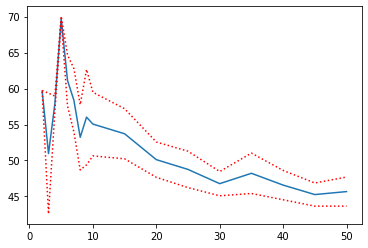

In [11]:
p_file = open(results_folder + 'KMeans_Coherence', 'rb')
tc_values_km = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(tc_values_km), axis=1)
ss = np.std(np.array(tc_values_km), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')


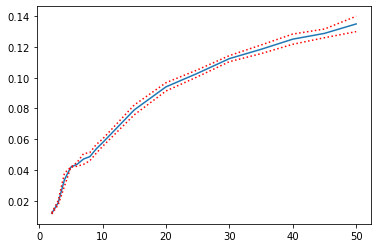

In [12]:
p_file = open(results_folder + 'KMeans_R2', 'rb')
r2_values_km = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(r2_values_km), axis=1)
ss = np.std(np.array(r2_values_km), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')

# Choosing K for LDA
Here we fit a LDA model 20 times for different K values. Then, we look at the coherences and adjusted $R^2$ for different K.

In [13]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
tc_values_lda = []
r2_values_lda = []
runs = 20
for k in k_values:
    print(f'running k = {k}')
    this_c = []
    this_r2 = []
    for run in range(runs):
        # build model
        lda = LDAModel(k)
        lda.fit(X_bds)
        
        # calculate coherence
        this_c.append(np.median(topic_coherence(lda.topic_vocab_matrix, 10, um_score_bds)))
        
        # work out adjusted r2
        features_sp500_df = pd.DataFrame(index=sp500_tickers, data=lda.transform(X_sp500))
        adj_r2_daily = daily_adjusted_r2(sp500_returns, features_sp500_df)
        this_r2.append(np.mean(adj_r2_daily.values))
        
    tc_values_lda.append(this_c)
    r2_values_lda.append(this_r2)

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
running k = 15
running k = 20
running k = 25
running k = 30
running k = 35
running k = 40
running k = 45
running k = 50


In [14]:
results_folder = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/Results/'
p_file = open(results_folder + 'LDA_Coherence', 'wb')
pickle.dump(tc_values_lda, p_file)
p_file.close()

p_file = open(results_folder + 'LDA_R2', 'wb')
pickle.dump(r2_values_lda, p_file)
p_file.close()

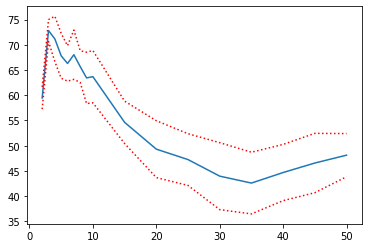

In [15]:
p_file = open(results_folder + 'LDA_Coherence', 'rb')
tc_values_lda = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(tc_values_lda), axis=1)
ss = np.std(np.array(tc_values_lda), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')

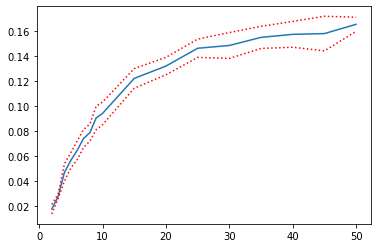

In [16]:
p_file = open(results_folder + 'LDA_R2', 'rb')
r2_values_lda = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(r2_values_lda), axis=1)
ss = np.std(np.array(r2_values_lda), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')

# Plotting Top Words

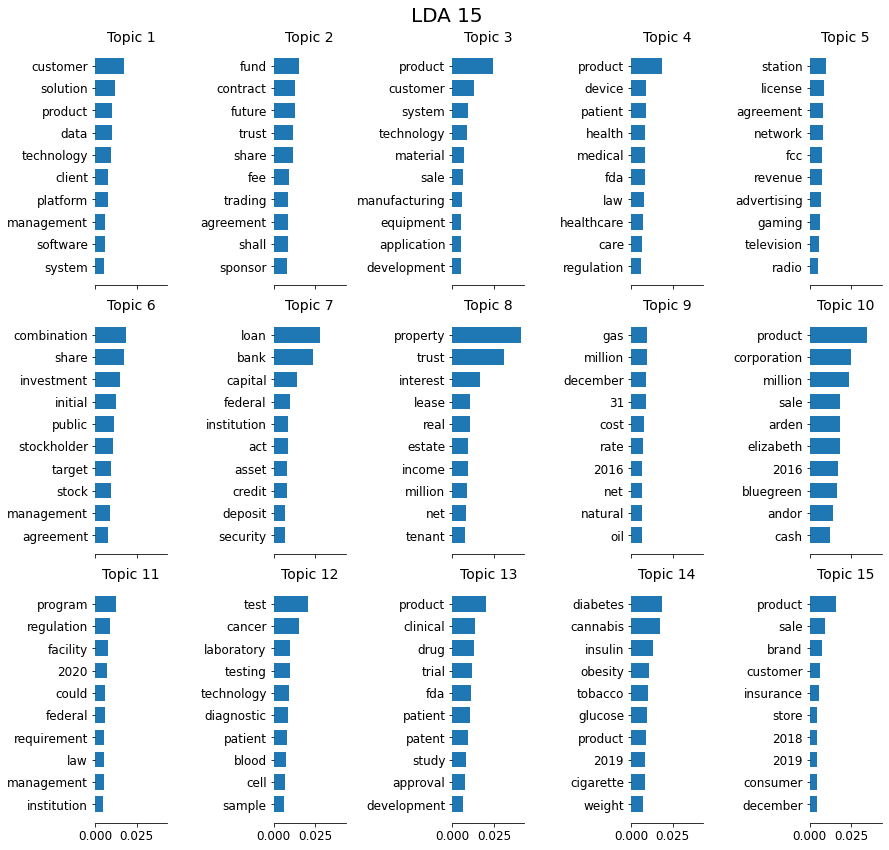

In [17]:
lda_15 = LDAModel(15)
lda_15.fit(X_bds)
plot_top_words(lda_15.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "LDA 15")

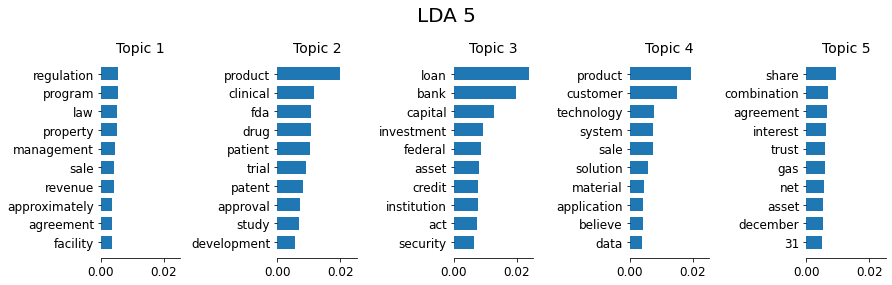

In [18]:
lda_5 = LDAModel(5)
lda_5.fit(X_bds)
plot_top_words(lda_5.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "LDA 5")

## K Means

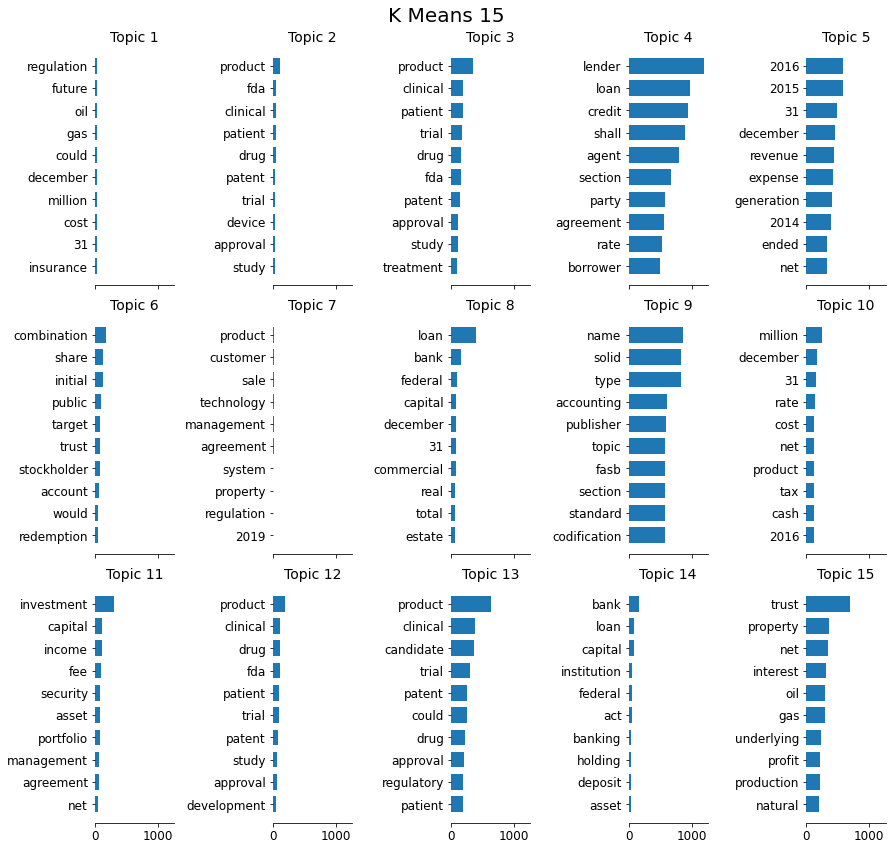

In [19]:
kmeans_15 = KMeansModel(15)
kmeans_15.fit(X_bds)
plot_top_words(kmeans_15.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "K Means 15")

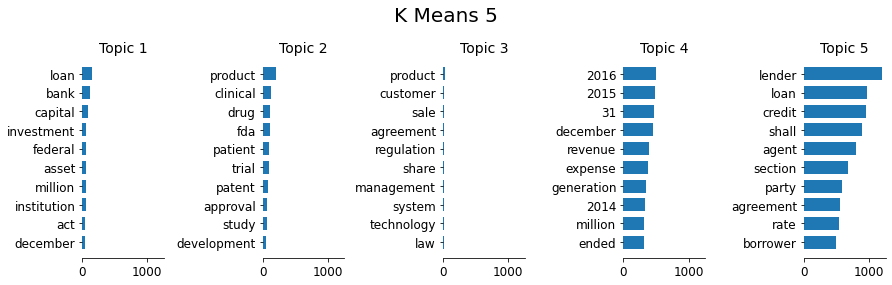

In [20]:
kmeans_5 = KMeansModel(5)
kmeans_5.fit(X_bds)
plot_top_words(kmeans_5.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "K Means 5")

## Stock Returns

In [21]:
features_sp500_df = pd.DataFrame(index=sp500_tickers, data=lda_15.transform(X_sp500))
adj_r2_lda_15 = daily_adjusted_r2(sp500_returns, features_sp500_df)

features_sp500_df = pd.DataFrame(index=sp500_tickers, data=kmeans_5.transform(X_sp500))
adj_r2_kmeans_5 = daily_adjusted_r2(sp500_returns, features_sp500_df)

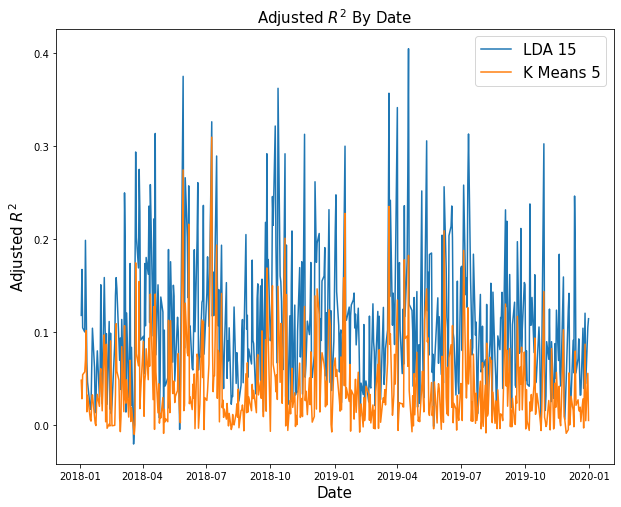

In [22]:
font_size=15
plt.figure(figsize=[10, 8])
plt.plot(adj_r2_lda_15)
plt.plot(adj_r2_kmeans_5)
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Adjusted $R^2$', fontsize=font_size)
plt.title('Adjusted $R^2$ By Date', fontsize=font_size)
plt.legend(['LDA 15', 'K Means 5'], fontsize=font_size);

# Classifier

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

## LDA

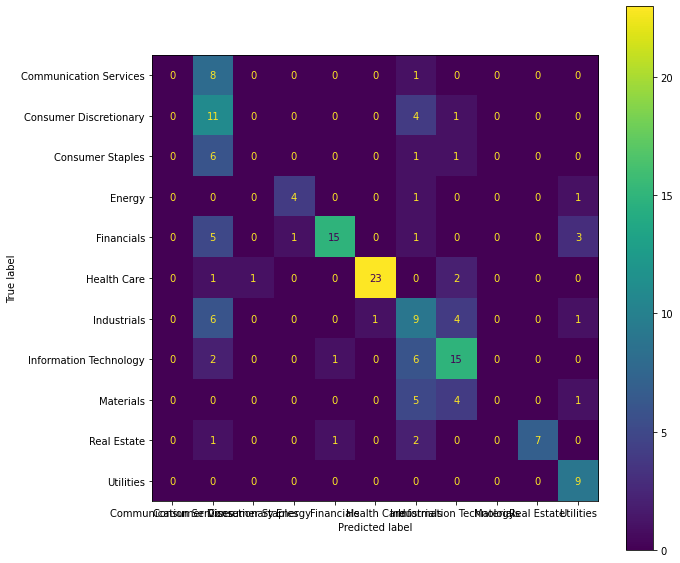

In [24]:
features_sp500_lda5 = lda_5.transform(X_sp500)
X_train, X_test, y_train, y_test = train_test_split(features_sp500_lda5, sp500_sectors, test_size=0.33, random_state=420)

my_svc = SVC()
my_svc.fit(X_train, y_train)
_, ax = plt.subplots(figsize=[10, 10])
plot_confusion_matrix(my_svc, X_test, y_test, ax=ax)

In [25]:
features_sp500_lda5 = lda_15.transform(X_sp500)
X_train, X_test, y_train, y_test = train_test_split(features_sp500_lda15, sp500_sectors, test_size=0.33, random_state=420)

my_svc = SVC(C=10)
my_svc.fit(X_train, y_train)
_, ax = plt.subplots(figsize=[10, 10])
plot_confusion_matrix(my_svc, X_test, y_test, ax=ax)

NameError: name 'features_sp500_lda15' is not defined